In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Harris Corner Detector**

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
# Sobel x-axis kernel
SOBEL_X = np.array((
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]), dtype="int32")

# Sobel y-axis kernel
SOBEL_Y = np.array((
    [-1, -2, -1],
    [0, 0, 0],
    [1, 2, 1]), dtype="int32")

# Gaussian kernel
GAUSS = np.array((
    [1/16, 2/16, 1/16],
    [2/16, 4/16, 2/16],
    [1/16, 2/16, 1/16]), dtype="float64")

In [4]:
def convolve(img, kernel):
    """
    Convolve function for odd dimensions.
    IT CONVOLVES IMAGES
    """
    if kernel.shape[0] % 2 != 1 or kernel.shape[1] % 2 != 1:
        raise ValueError("Only odd dimensions on filter supported")

    img_height = img.shape[0]
    img_width = img.shape[1]
    pad_height = kernel.shape[0] // 2
    pad_width = kernel.shape[1] // 2
    
    pad = ((pad_height, pad_height), (pad_height, pad_width))
    g = np.empty(img.shape, dtype=np.float64)
    img = np.pad(img, pad, mode='constant', constant_values=0)
    # Do convolution
    for i in np.arange(pad_height, img_height+pad_height):
        for j in np.arange(pad_width, img_width+pad_width):
            roi = img[i - pad_height:i + pad_height +
                      1, j - pad_width:j + pad_width + 1]
            g[i - pad_height, j - pad_width] = (roi*kernel).sum()

    if (g.dtype == np.float64):
        kernel = kernel / 255.0
        kernel = (kernel*255).astype(np.uint8)
    else:
        g = g + abs(np.amin(g))
        g = g / np.amax(g)
        g = (g*255.0)
    return g

In [5]:
def harris(img, threshold=0.6):

    img_cpy = img.copy() # copying image

    img1_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # grayscaling (0-1)

    dx = convolve(img1_gray, SOBEL_X) # convolving with sobel filter on X-axis
    dy = convolve(img1_gray, SOBEL_Y) # convolving with sobel filter on Y-axis
    # square of derivatives
    dx2 = np.square(dx)
    dy2 = np.square(dy)
    dxdy = dx*dy #cross filtering
    # gauss filter for all directions (x,y,cross axis)
    g_dx2 = convolve(dx2, GAUSS)
    g_dy2 = convolve(dy2, GAUSS)
    g_dxdy = convolve(dxdy, GAUSS)
    # Harris Function
    harris = g_dx2*g_dy2 - np.square(g_dxdy) - 0.12*np.square(g_dx2 + g_dy2) # r(harris) = det - k*(trace**2)
    # Normalizing inside (0-1)
    cv2.normalize(harris, harris, 0, 1, cv2.NORM_MINMAX)

    # find all points above threshold (nonmax supression line)
    loc = np.where(harris >= threshold)
    # drawing filtered points
    for pt in zip(*loc[::-1]):
        cv2.circle(img_cpy, pt, 3, (0, 0, 255), -1)

    return img_cpy,g_dx2,g_dy2,dx,dy,loc

In [6]:
img = cv2.imread('/content/drive/MyDrive/box.PNG')
#img = cv2.imread('/content/drive/MyDrive/chess.png')

corners,g_dx2,g_dy2,dx,dy,loc = harris(img,0.7)


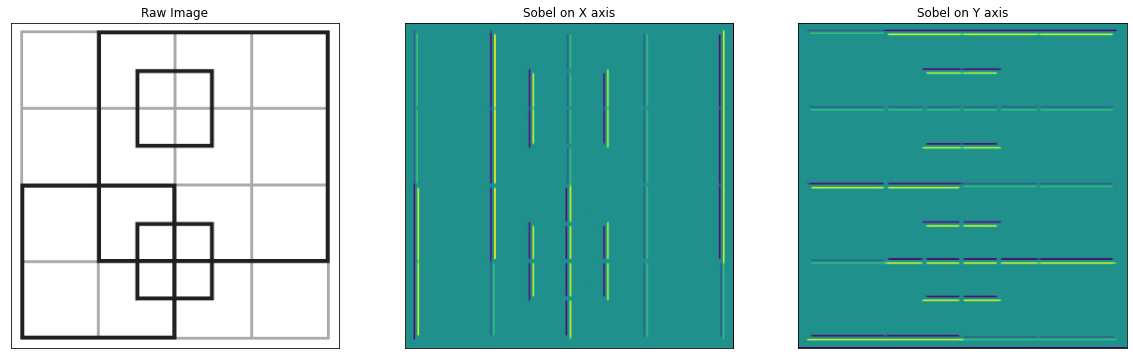

In [7]:
# display raw & filtered images
plt.figure(figsize=(20, 20))
plt.subplot(131), plt.imshow(img)
plt.title("Raw Image"), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(dx)
plt.title("Sobel on X axis"), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(dy)
plt.title("Sobel on Y axis"), plt.xticks([]), plt.yticks([])
plt.show()

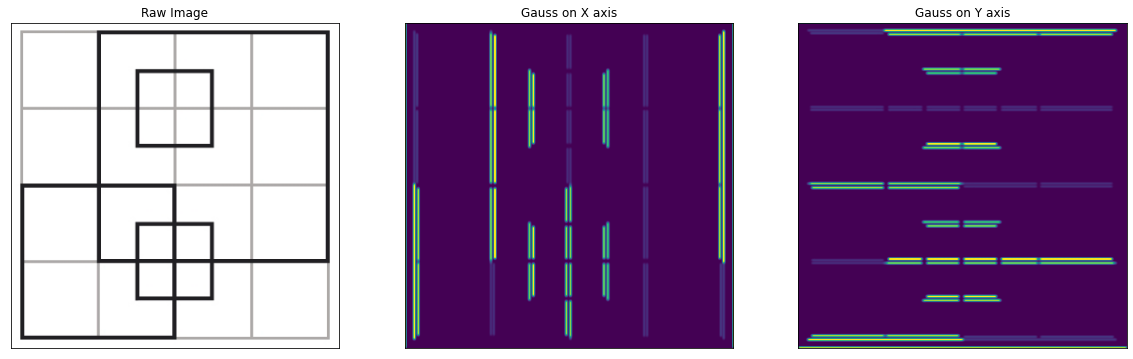

In [8]:
plt.figure(figsize=(20, 20))
plt.subplot(131), plt.imshow(img)
plt.title("Raw Image"), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(g_dx2)
plt.title("Gauss on X axis"), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(g_dy2)
plt.title("Gauss on Y axis"), plt.xticks([]), plt.yticks([])
plt.show()

(Text(0.5, 1.0, 'Harris Corner Output'),
 ([], <a list of 0 Text major ticklabel objects>),
 ([], <a list of 0 Text major ticklabel objects>))

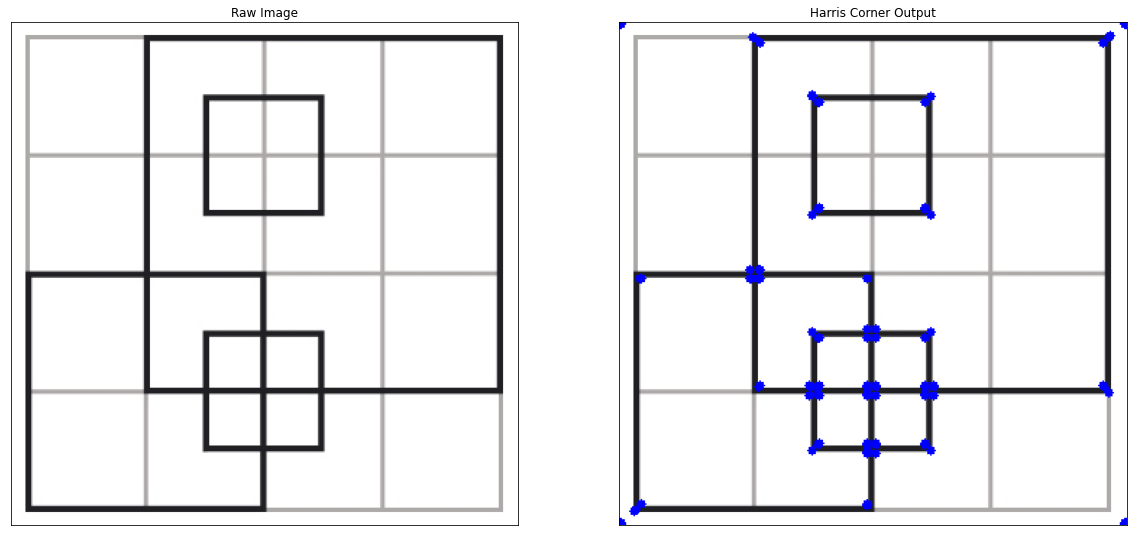

In [9]:
plt.figure(figsize=(20, 20))
plt.subplot(121), plt.imshow(img)
plt.title("Raw Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(corners)
plt.title("Harris Corner Output"), plt.xticks([]), plt.yticks([])

**Lines Detection with Hough Transform**

Non-Vectorized Solution

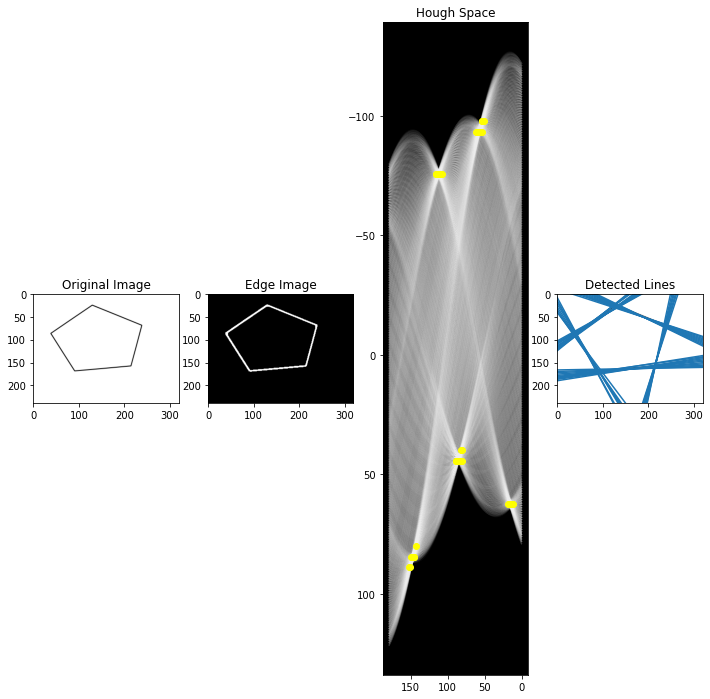

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines


def line_detection_non_vectorized(image, edge_image, num_rhos=180, num_thetas=180, t_count=220):
  edge_height, edge_width = edge_image.shape[:2]

  edge_height_half, edge_width_half = edge_height / 2, edge_width / 2
  #
  d = np.sqrt(np.square(edge_height) + np.square(edge_width))
  dtheta = 180 / num_thetas
  drho = (2 * d) / num_rhos
  #
  thetas = np.arange(0, 180, step=dtheta)
  rhos = np.arange(-d, d, step=drho)
  #
  cos_thetas = np.cos(np.deg2rad(thetas))
  sin_thetas = np.sin(np.deg2rad(thetas))
  #
  accumulator = np.zeros((len(rhos), len(rhos)))
  #
  figure = plt.figure(figsize=(12, 12))
  subplot1 = figure.add_subplot(1, 4, 1)
  subplot1.imshow(image)
  subplot2 = figure.add_subplot(1, 4, 2)
  subplot2.imshow(edge_image, cmap="gray")
  subplot3 = figure.add_subplot(1, 4, 3)
  subplot3.set_facecolor((0, 0, 0))
  subplot4 = figure.add_subplot(1, 4, 4)
  subplot4.imshow(image)
  #
  for y in range(edge_height):
    for x in range(edge_width):
      if edge_image[y][x] != 0:
        edge_point = [y - edge_height_half, x - edge_width_half]
        ys, xs = [], []
        for theta_idx in range(len(thetas)):
          rho = (edge_point[1] * cos_thetas[theta_idx]) + (edge_point[0] * sin_thetas[theta_idx])
          theta = thetas[theta_idx]
          rho_idx = np.argmin(np.abs(rhos - rho))
          accumulator[rho_idx][theta_idx] += 1
          ys.append(rho)
          xs.append(theta)
        subplot3.plot(xs, ys, color="white", alpha=0.05)

  for y in range(accumulator.shape[0]):
    for x in range(accumulator.shape[1]):
      if accumulator[y][x] > t_count:
        rho = rhos[y]
        theta = thetas[x]
        a = np.cos(np.deg2rad(theta))
        b = np.sin(np.deg2rad(theta))
        x0 = (a * rho) + edge_width_half
        y0 = (b * rho) + edge_height_half
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        subplot3.plot([theta], [rho], marker='o', color="yellow")
        subplot4.add_line(mlines.Line2D([x1, x2], [y1, y2]))

  subplot3.invert_yaxis()
  subplot3.invert_xaxis()

  subplot1.title.set_text("Original Image")
  subplot2.title.set_text("Edge Image")
  subplot3.title.set_text("Hough Space")
  subplot4.title.set_text("Detected Lines")
  plt.show()
  return accumulator, rhos, thetas


if __name__ == "__main__":
    image = cv2.imread('/content/drive/MyDrive/pentagon.PNG')
    edge_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edge_image = cv2.GaussianBlur(edge_image, (3, 3), 1)
    edge_image = cv2.Canny(edge_image, 100, 200)
    edge_image = cv2.dilate(
        edge_image,
        cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5)),
    )
    edge_image = cv2.erode(
        edge_image,
        cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5)),
    )
    line_detection_non_vectorized(image, edge_image)

**circle hough transform**

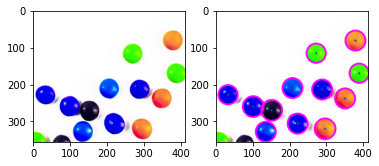

In [12]:
import sys
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

    
# Loads an image
src = cv.imread('/content/drive/MyDrive/smarties.png')
plt.subplot(1,2,1)
plt.imshow(src)
    
gray = cv.cvtColor(src, cv.COLOR_BGR2GRAY)
    
    
gray = cv.medianBlur(gray, 5)
    
    
rows = gray.shape[0]
circles = cv.HoughCircles(gray, cv.HOUGH_GRADIENT, 1, rows / 8,
                               param1=100, param2=30,
                               minRadius=1, maxRadius=30)
    
    
if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles[0, :]:
      center = (i[0], i[1])
      # circle center
      cv.circle(src, center, 1, (0, 100, 100), 3)
      # circle outline
      radius = i[2]
      cv.circle(src, center, radius, (255, 0, 255), 3)

    plt.subplot(1,2,2)
    plt.imshow( src)
    plt.show()
